In [1]:
import rasterio
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import rasterio.mask
import rioxarray as rxr

npp data

In [ ]:
ds = xr.open_dataset('_/npp_east_european_fsteppe.nc') # npp array for all years for one ecoregion
print(ds)

<xarray.Dataset> Size: 1GB
Dimensions:  (band: 24, x: 6107, y: 2356)
Coordinates:
  * band     (band) int32 96B 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * x        (x) float64 49kB 2.924e+06 2.926e+06 ... 1.513e+07 1.514e+07
  * y        (y) float64 19kB 7.855e+06 7.853e+06 ... 3.147e+06 3.145e+06
Data variables:
    NPP      (band, y, x) float32 1GB ...
Attributes:
    Conventions:      CF-1.0
    Source_Software:  Esri ArcGIS


In [ ]:
var_name = list(ds.data_vars.keys())[0]  # variable name (NPP)
data_array = ds[var_name]  
years = ds['band'].values  # years

In [26]:
df = data_array.to_dataframe().reset_index()

In [ ]:
df = df.dropna()

In [ ]:
df.to_csv("_/npp_east_european_fsteppe.csv", index=False) 

In [ ]:
df = pd.read_csv("_/npp_east_european_fsteppe.csv")
print(df.head())
print(df.columns)

   band             y             x     NPP
0     1  7.855125e+06  6.329764e+06  0.4635
1     1  7.855125e+06  6.331764e+06  0.4398
2     1  7.855125e+06  6.333764e+06  0.4318
3     1  7.855125e+06  6.335764e+06  0.4304
4     1  7.855125e+06  6.337764e+06  0.4851
Index(['band', 'y', 'x', 'NPP'], dtype='object')


In [4]:
df = df.rename(columns={'band': 'year'})
df['year'] = df['year'] + 2000 # updating years column from 2001 to 2024

In [5]:
print(df.head())
print(df.columns)

   year             y             x     NPP
0  2001  7.855125e+06  6.329764e+06  0.4635
1  2001  7.855125e+06  6.331764e+06  0.4398
2  2001  7.855125e+06  6.333764e+06  0.4318
3  2001  7.855125e+06  6.335764e+06  0.4304
4  2001  7.855125e+06  6.337764e+06  0.4851
Index(['year', 'y', 'x', 'NPP'], dtype='object')


In [6]:
quantiles = [0.99, 0.95, 0.5, 0.05, 0.01]
X = df['year'].values.reshape(-1, 1)
y = df['NPP'].values
X = sm.add_constant(X)

In [7]:
models = {} # results of quantile regression
slopes = {} # slopes of trends for comparison
for q in quantiles:
    model = sm.QuantReg(y, X).fit(q=q)
    models[q] = model
    slopes[q] = model.params[1]

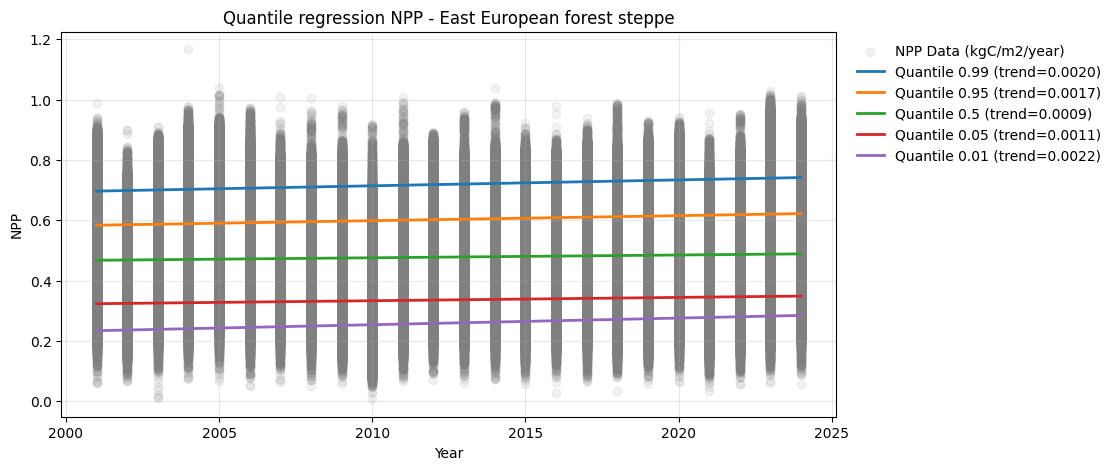

In [8]:
plt.figure(figsize=(10, 5))
plt.scatter(df['year'], df['NPP'], alpha=0.1, color='gray', label='NPP Data (kgC/m2/year)')

predictions = {}
for q in quantiles:
    X_pred = sm.add_constant(df['year'].values.reshape(-1, 1))
    y_pred = models[q].predict(X_pred)
    predictions[q] = y_pred 
    slope = slopes[q]
    plt.plot(df['year'], y_pred, label=f'Quantile {q} (trend={slope:.4f})', linewidth=2)

plt.xlabel('Year')
plt.ylabel('NPP')
plt.title('Quantile regression NPP - East European forest steppe')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)
plt.grid(alpha=0.3)
plt.show()

same for nee data

In [ ]:
ds = xr.open_dataset('_/nee_east_european_fsteppe.nc')
print(ds)

<xarray.Dataset> Size: 55kB
Dimensions:  (band: 10, x: 59, y: 23)
Coordinates:
  * band     (band) int32 40B 1 2 3 4 5 6 7 8 9 10
  * x        (x) float64 472B 2.894e+06 3.103e+06 ... 1.483e+07 1.504e+07
  * y        (y) float64 184B 7.768e+06 7.559e+06 ... 3.37e+06 3.161e+06
Data variables:
    NEE      (band, y, x) float32 54kB ...
Attributes:
    Conventions:      CF-1.0
    Source_Software:  Esri ArcGIS


In [4]:
var_name = list(ds.data_vars.keys())[0]  # Имя переменной (NEE)
data_array = ds[var_name]  # Берем NEE
years = ds['band'].values  # Годы

In [5]:
df = data_array.to_dataframe().reset_index()

In [6]:
df = df.dropna()

In [ ]:
df.to_csv("_/nee_east_european_fsteppe.csv", index=False)

In [10]:
df = pd.read_csv("D:/diplom/quantile regression/nee_east_european_fsteppe.csv")
print(df.head())
print(df.columns)

   band             y             x         NEE
0     1  7.558581e+06  4.987682e+06  147.476400
1     1  7.558581e+06  5.197097e+06   78.806880
2     1  7.558581e+06  6.453592e+06  -12.760908
3     1  7.349165e+06  4.150018e+06   21.659437
4     1  7.349165e+06  4.359434e+06   34.363960
Index(['band', 'y', 'x', 'NEE'], dtype='object')


In [11]:
df = df.rename(columns={'band': 'year'})
df['year'] = df['year'] + 2009 # updating years column from 2010 to 2019

In [12]:
# outlier trimming
lower_bound = df['NEE'].quantile(0.000001)
upper_bound = df['NEE'].quantile(0.999999)
df = df[(df['NEE'] >= lower_bound) & (df['NEE'] <= upper_bound)]

In [13]:
print(df.head())
print(df.columns)

   year             y             x         NEE
0  2010  7.558581e+06  4.987682e+06  147.476400
1  2010  7.558581e+06  5.197097e+06   78.806880
2  2010  7.558581e+06  6.453592e+06  -12.760908
3  2010  7.349165e+06  4.150018e+06   21.659437
4  2010  7.349165e+06  4.359434e+06   34.363960
Index(['year', 'y', 'x', 'NEE'], dtype='object')


In [14]:
quantiles = [0.99, 0.95, 0.5, 0.05, 0.01]
X = df['year'].values.reshape(-1, 1) 
y = df['NEE'].values
X = sm.add_constant(X)

In [15]:
models = {}
slopes = {}
for q in quantiles:
    model = sm.QuantReg(y, X).fit(q=q)
    models[q] = model
    slopes[q] = model.params[1]

c:\Users\varva\venvs\global_env\venv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\varva\venvs\global_env\venv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\varva\venvs\global_env\venv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\varva\venvs\global_env\venv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\varva\venvs\global_env\venv

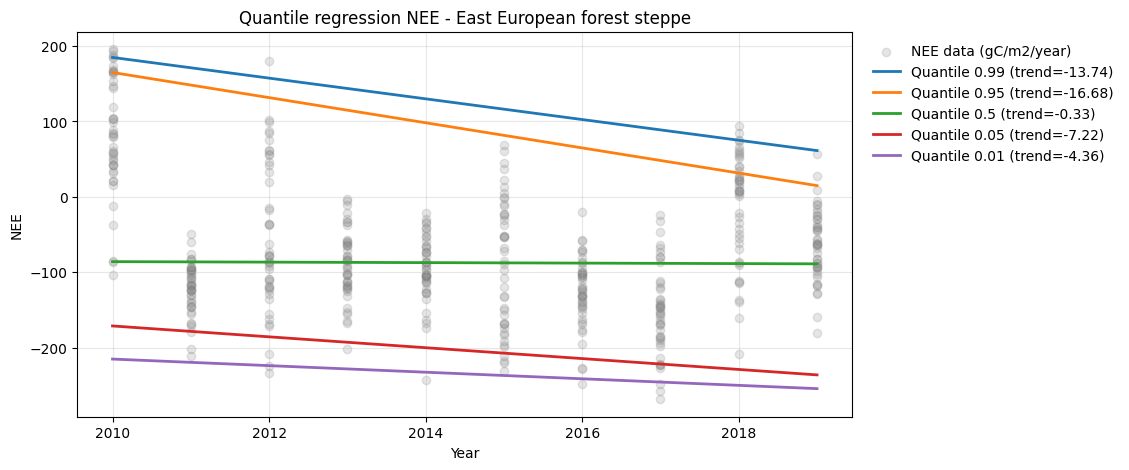

In [16]:
plt.figure(figsize=(10, 5))
plt.scatter(df['year'], df['NEE'], alpha=0.2, color='gray', label='NEE data (gC/m2/year)')

predictions = {}
for q in quantiles:
    X_pred = sm.add_constant(df['year'].values.reshape(-1, 1))
    y_pred = models[q].predict(X_pred)
    predictions[q] = y_pred  
    slope = slopes[q]
    plt.plot(df['year'], y_pred, label=f'Quantile {q} (trend={slope:.2f})', linewidth=2)

plt.xlabel('Year')
plt.ylabel('NEE')
plt.title('Quantile regression NEE - East European forest steppe')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)
plt.grid(alpha=0.3)
plt.show()